# Importing Libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Loading the Data

In [2]:
SEED = 42 # For reprodicibility
IMG_SIZE = (256, 256)

# ----- Creating a train dataset object (tf.data.Dataset)----- #
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    directory='../datasets/train',
    label_mode='categorical',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=32,
    labels='inferred',
)
# ----- Creating a test dataset object (tf.data.Dataset)----- #
test_set = tf.keras.preprocessing.image_dataset_from_directory(
  directory='../datasets/test', 
  label_mode='categorical',
  seed=SEED,
  image_size=IMG_SIZE,
  batch_size=32,
  labels='inferred',
)

# ----- Creating a validation dataset object (tf.data.Dataset)----- #
val_set = tf.keras.preprocessing.image_dataset_from_directory(
  directory='../datasets/validation',
  label_mode='categorical',
  seed=SEED,
  image_size=IMG_SIZE,
  batch_size=32,
  labels='inferred',
)

Found 1034 files belonging to 3 classes.
Found 128 files belonging to 3 classes.
Found 133 files belonging to 3 classes.


# Visualizing Samples from Dataset

In [3]:
# Category list
class_names = train_set.class_names

# Visualizing samples from the training set
class_images = {cat: [] for cat in class_names}

for image, label in train_set.unbatch():
    cat = class_names[np.argmax(label.numpy())]
    # Take 5 images per class
    if len(class_images[cat]) < 5:
        class_images[cat].append(image.numpy())
    if all(len(images) >= 5 for images in class_images.values()):
        break

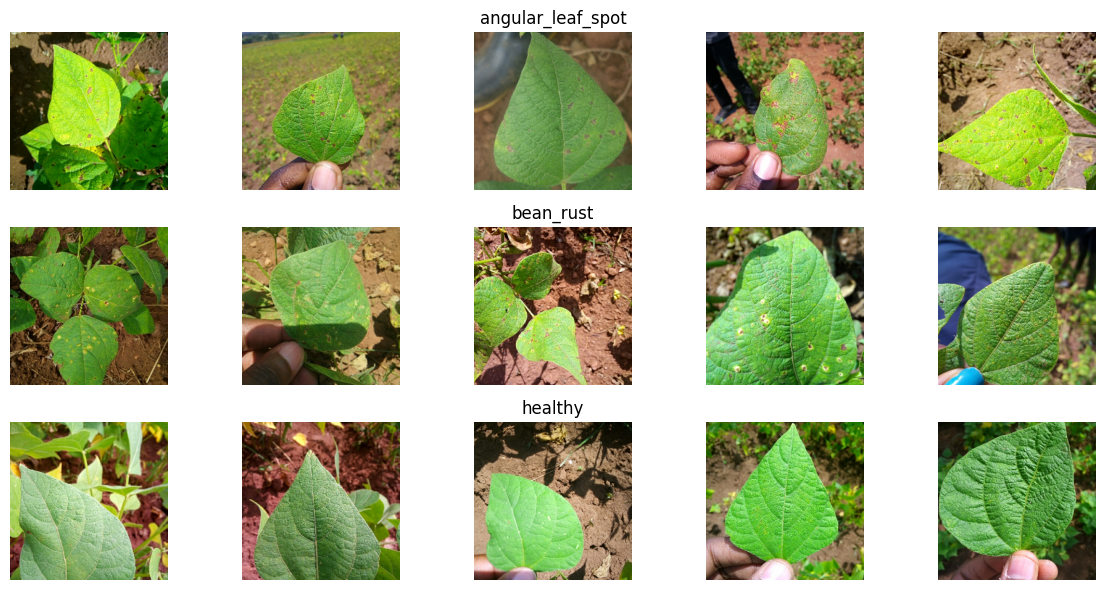

In [4]:
# Function for plotting the sample images
def plot_images(cnames: list, cimages: dict):
    fig, axes = plt.subplots(len(cnames), 5, figsize=(12, 6))

    for i, cat in enumerate(cnames):
        for j in range(5):
            if j < len(cimages[cat]):
                ax = axes[i, j]
                ax.imshow(cimages[cat][j] / 255.) # /255. to normalize RGB values of image
                # Turn off ticks for better display
                ax.axis('off')
                # Placing category name at middle image
                if j == 2:
                    ax.set_title(cat) 
    plt.tight_layout()
    # plt.savefig('../images/dataset_prev.png')
    plt.show()

# Plot the images
plot_images(class_names, class_images)

# CNN Model Creation and Training

## Creating the Model

In [5]:
# Function for creating network architecture
def create_cnn(input_shape: tuple) -> any:
    model = tf.keras.Sequential()
    # Add an input layer
    model.add(tf.keras.layers.Input(shape=input_shape))

    # Convolutional blocks
    ## Block 1
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
    ## Block 2
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
    ## Block 3
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))

    # Global Average Pooling layer
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    
    # Dense (fully connected) blocks
    model.add(tf.keras.layers.Dense(units=256, kernel_regularizer='l2', activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5)) 
    model.add(tf.keras.layers.Dense(units=128, kernel_regularizer='l2', activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    # Output layer
    model.add(tf.keras.layers.Dense(units=len(train_set.class_names), activation='softmax'))

    return model

In [6]:
beanCNN = create_cnn(
    input_shape=(256, 256, 3)
)
beanCNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 256)      0

## Compiling the Model

In [7]:
beanCNN.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath='../models/best_beanCNN.h5', monitor='accuracy', save_best_only=True)
]

## Training the Model on the Training Set

In [8]:
beanCNN_history = beanCNN.fit(
    train_set, 
    validation_data=val_set,
    epochs=50,
    callbacks=callbacks,
)

Epoch 1/30
33/33 [==============================] - 12s 183ms/step - loss: 6.3924 - accuracy: 0.3317 - val_loss: 3.0346 - val_accuracy: 0.5038
Epoch 2/30
33/33 [==============================] - 5s 137ms/step - loss: 2.9285 - accuracy: 0.3985 - val_loss: 2.6904 - val_accuracy: 0.5038
Epoch 3/30
33/33 [==============================] - 5s 138ms/step - loss: 2.6523 - accuracy: 0.4729 - val_loss: 2.4625 - val_accuracy: 0.5639
Epoch 4/30
33/33 [==============================] - 5s 139ms/step - loss: 2.4887 - accuracy: 0.4642 - val_loss: 2.3299 - val_accuracy: 0.5038
Epoch 5/30
33/33 [==============================] - 5s 141ms/step - loss: 2.3680 - accuracy: 0.4681 - val_loss: 2.2567 - val_accuracy: 0.5113
Epoch 6/30
33/33 [==============================] - 5s 141ms/step - loss: 2.2591 - accuracy: 0.4903 - val_loss: 2.1042 - val_accuracy: 0.5338
Epoch 7/30
33/33 [==============================] - 5s 144ms/step - loss: 2.1554 - accuracy: 0.5087 - val_loss: 2.1287 - val_accuracy: 0.4812
Epoch